In [2]:
import torch
import clip
from PIL import Image

clip.available_models()


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 44.3MiB/s]


#### test CLIP.png (local)

In [18]:
image = Image.open("CLIP.png")
image.show()

In [16]:
image = preprocess(image).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<function matplotlib.pyplot.show(close=None, block=None)>

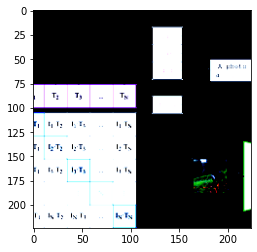

In [17]:
import matplotlib.pyplot as plt

plt.imshow(image.squeeze().permute(1,2,0).cpu())
plt.show

In [8]:
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]

Label probs: [[0.99279344 0.00421076 0.00299581]]


#### test zero-shot prediction using CIFAR100

In [10]:
from torchvision.datasets import CIFAR100
import os
# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /Users/ihyeonseung/.cache/cifar-100-python.tar.gz to /Users/ihyeonseung/.cache


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


78


<function matplotlib.pyplot.show(close=None, block=None)>

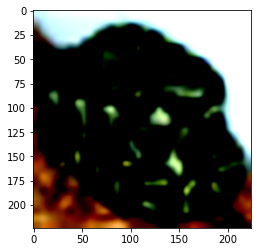

In [26]:
# Prepare the inputs
image, class_id = cifar100[3637]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

print(class_id)
plt.imshow(image_input.squeeze().permute(1,2,0).cpu())
plt.show

In [21]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

           snake: 65.31%
          turtle: 12.29%
    sweet_pepper: 3.83%
          lizard: 1.87%
       crocodile: 1.75%
